In [1]:
%run tools.ipynb

In [2]:
# 0.5 degree data
file_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/data/sacks2010/'
file_name = 'Maize.crop.calendar.fill.nc' # replace 'Maize' with Rice, Soybean, Wheat

ds = xr.open_dataset(file_dir + file_name)
ds = ds.rename({"longitude":"lon", "latitude":"lat"})
ds

<xarray.Dataset>
Dimensions:        (lat: 360, lon: 720)
Coordinates:
  * lon            (lon) float64 -179.7 -179.2 -178.7 ... 178.8 179.3 179.8
  * lat            (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
Data variables:
    index          (lat, lon) float32 ...
    filled.index   (lat, lon) float32 ...
    plant          (lat, lon) float32 ...
    plant.start    (lat, lon) float32 ...
    plant.end      (lat, lon) float32 ...
    plant.range    (lat, lon) timedelta64[ns] ...
    harvest        (lat, lon) float32 ...
    harvest.start  (lat, lon) float32 ...
    harvest.end    (lat, lon) float32 ...
    harvest.range  (lat, lon) timedelta64[ns] ...
    tot.days       (lat, lon) timedelta64[ns] ...
Attributes:
    notes:    Extrapolation done WITH paying attention to misclassified flag

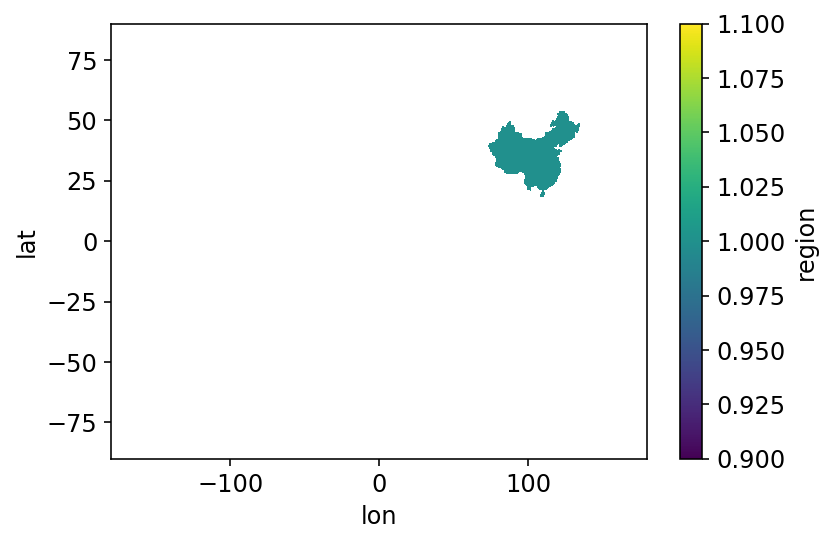

In [3]:
# make China mask
dr_tmp = ds['harvest']

mask1 = regionmask.defined_regions.natural_earth.countries_110.mask(dr_tmp)
country_mean = dr_tmp.groupby(mask1).mean('stacked_lat_lon')
names = regionmask.defined_regions.natural_earth.countries_110[country_mean.region.values].names

names.index('China') # index of China, 139

mask_china = mask1.where(mask1 == 139) - 138 # keep China mask, China = 1, Other = 0

mask_china.plot()

In [4]:
maize_harvest = ds['harvest'] * mask_china

In [5]:
# plot XY range
lat1 = 18
lat2 = 55
lon1 = 72
lon2 = 135

In [6]:
# China provincial borders 
with open(r'/Users/mehliyarsadiq/Desktop/ozone_crop/data/CN-border-La.dat') as src:
    context = ''.join([line for line in src if not line.startswith('#')])
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


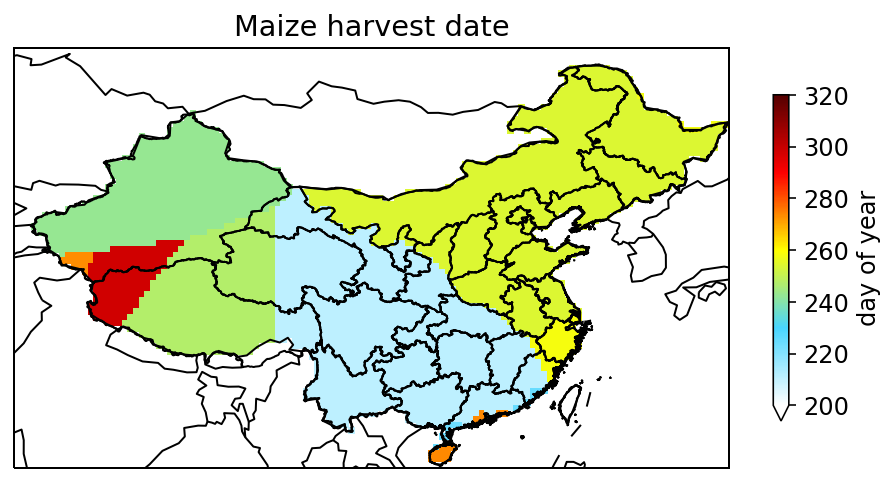

In [7]:
import cartopy.feature as cfeature

fig = plt.figure(figsize=[8, 6])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
ax.coastlines()
maize_harvest.plot(ax = ax,
                  transform=ccrs.PlateCarree(), 
                  cmap=WhGrYlRd, 
                  vmin = 200,
                  vmax = 320,
                  cbar_kwargs={'shrink': 0.5, 'label': 'day of year'})

ax.set_xlim(lon1,lon2)
ax.set_ylim(lat1,lat2)
ax.set_title('Maize harvest date')
ax.add_feature(cfeature.BORDERS)

# China borders
for line in borders:
    ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/china/'
fig.savefig(out_dir + 'harvest_date_China.png', dpi = 300, bbox_inches = "tight")


In [8]:
# Rice
file_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/data/sacks2010/'
file_name = 'Rice.crop.calendar.fill.nc' 

ds = xr.open_dataset(file_dir + file_name)
ds = ds.rename({"longitude":"lon", "latitude":"lat"})
rice_harvest = ds['harvest']* mask_china

# Soybean
file_name = 'Soybeans.crop.calendar.fill.nc' 

ds = xr.open_dataset(file_dir + file_name)
ds = ds.rename({"longitude":"lon", "latitude":"lat"})
soybean_harvest = ds['harvest']* mask_china

# Wheat
file_name = 'Wheat.crop.calendar.fill.nc' 

ds = xr.open_dataset(file_dir + file_name)
ds = ds.rename({"longitude":"lon", "latitude":"lat"})
wheat_harvest = ds['harvest']* mask_china


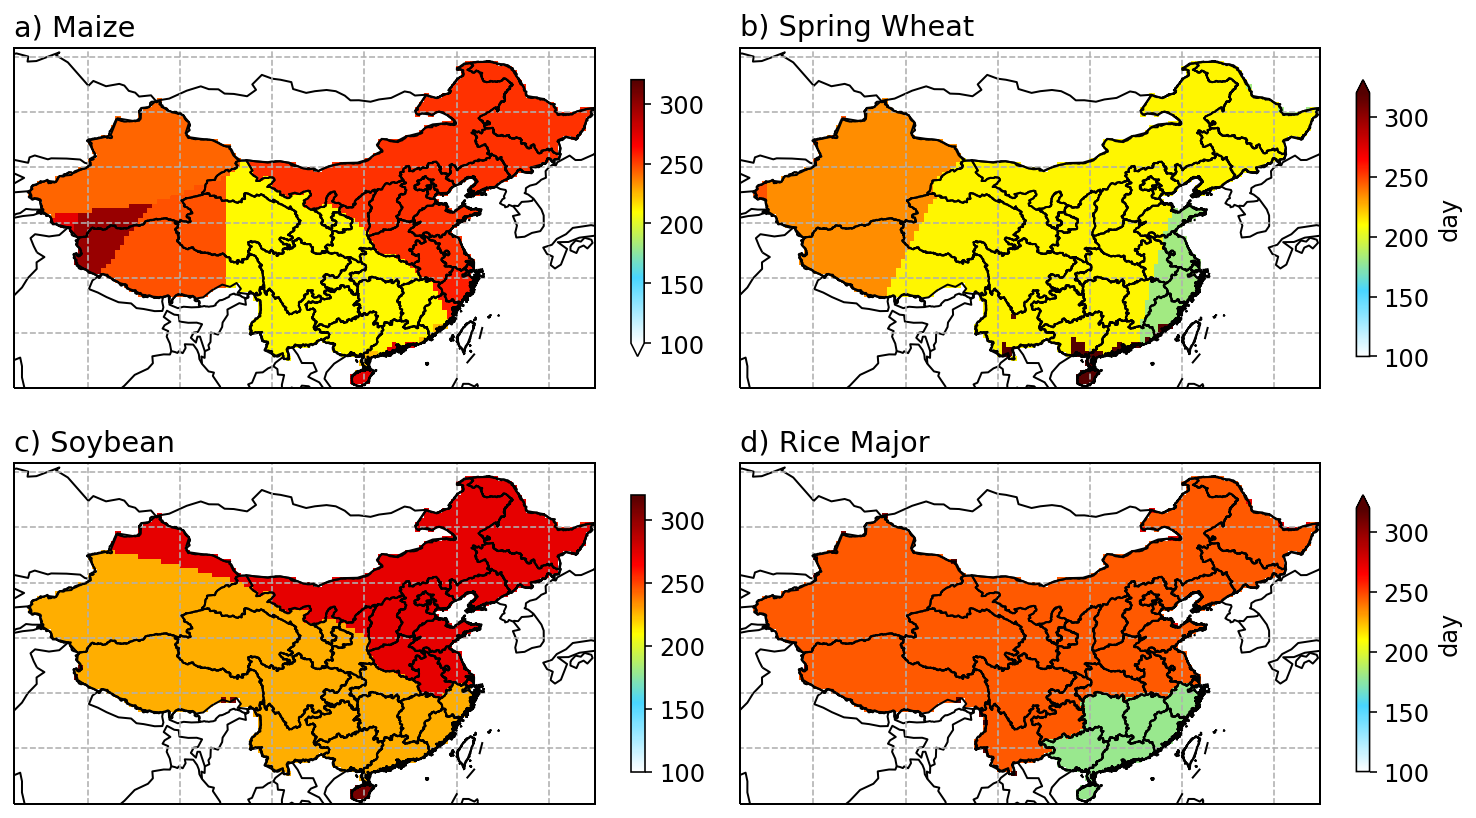

In [19]:

order_crops = ['a) Maize', 'b) Spring Wheat', 'c) Soybean', 'd) Rice Major']

lim_max = 320
lim_min = 100

shrink = 0.8

# figure 1, distribution
fig, axes = plt.subplots(2, 2, 
                             figsize=[13, 7], 
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             gridspec_kw={'hspace': 0.2, 'wspace': 0})
# before
maize_harvest.plot(ax=axes[0,0],
                  cmap=WhGrYlRd,
                  vmin = lim_min,
                  vmax = lim_max, 
                  add_labels = False,
                  cbar_kwargs={'shrink': shrink})
axes[0,0].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[0,0].set_title(order_crops[0], loc='left')
axes[0,0].coastlines()
axes[0,0].gridlines(linestyle = '--')
axes[0,0].add_feature(cfeature.BORDERS)

# China borders
for line in borders:
    axes[0,0].plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

# after
wheat_harvest.plot(ax=axes[0,1], 
                cmap=WhGrYlRd, 
                vmin = lim_min,
                vmax = lim_max, 
                cbar_kwargs={'shrink': shrink, 'label': 'day'})
axes[0,1].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[0,1].set_title(' ')
axes[0,1].set_title(order_crops[1], loc='left')
#axes[1].set_title('mean: ' + str(model_mean), loc = 'right')
axes[0,1].coastlines()
axes[0,1].gridlines(linestyle = '--')
axes[0,1].add_feature(cfeature.BORDERS)
# China borders
for line in borders:
    axes[0,1].plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())


soybean_harvest.plot(ax=axes[1,0],
                  cmap=WhGrYlRd,
                  vmin = lim_min,
                  vmax = lim_max,
                  add_labels = False,
                  cbar_kwargs={'shrink': shrink})
axes[1,0].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[1,0].set_title(order_crops[2], loc='left')
#axes[0].set_title('mean: ' + str(obs_mean), loc = 'right')
axes[1,0].coastlines()
axes[1,0].gridlines(linestyle = '--')
axes[1,0].add_feature(cfeature.BORDERS)
# China borders
for line in borders:
    axes[1,0].plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

# after
rice_harvest.plot(ax=axes[1,1], 
                cmap=WhGrYlRd, 
                vmin = lim_min,
                vmax = lim_max, 
                cbar_kwargs={'shrink': shrink, 'label': 'day'})
axes[1,1].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[1,1].set_title(' ')
axes[1,1].set_title(order_crops[3], loc='left')
#axes[1].set_title('mean: ' + str(model_mean), loc = 'right')
axes[1,1].coastlines()
axes[1,1].gridlines(linestyle = '--')
axes[1,1].add_feature(cfeature.BORDERS)

# China borders
for line in borders:
    axes[1,1].plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

# save figure
out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/china/'
fig.savefig(out_dir + 'harvest_date_4crops.png', dpi = 300, bbox_inches = "tight")


In [10]:
# secondary growing season
# Rice
file_name = 'Rice.2.crop.calendar.fill.nc' 

ds = xr.open_dataset(file_dir + file_name)
ds = ds.rename({"longitude":"lon", "latitude":"lat"})
rice2_harvest = ds['harvest'] * mask_china.values

In [11]:
# secondary growing season
# Wheat
file_name = 'Wheat.Winter.crop.calendar.fill.nc' 

ds = xr.open_dataset(file_dir + file_name)
ds = ds.rename({"longitude":"lon", "latitude":"lat"})
wheat2_harvest = ds['harvest'] * mask_china

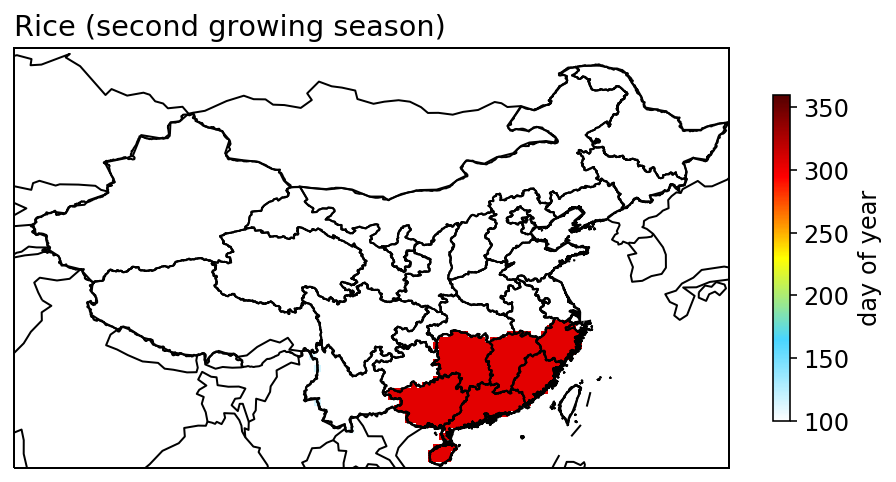

In [14]:
import cartopy.feature as cfeature

fig = plt.figure(figsize=[8, 6])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
ax.coastlines()
rice2_harvest.plot(ax = ax,
                  transform=ccrs.PlateCarree(), 
                  cmap=WhGrYlRd, 
                  vmin = 100,
                  vmax = 360,
                  cbar_kwargs={'shrink': 0.5, 'label': 'day of year'})

ax.set_xlim(lon1,lon2)
ax.set_ylim(lat1,lat2)
ax.set_title('Rice (second growing season)', loc = 'left')
ax.add_feature(cfeature.BORDERS)

# China borders
for line in borders:
    ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/china/'
#fig.savefig(out_dir + 'harvest_date_rice.2.png', dpi = 300, bbox_inches = "tight")


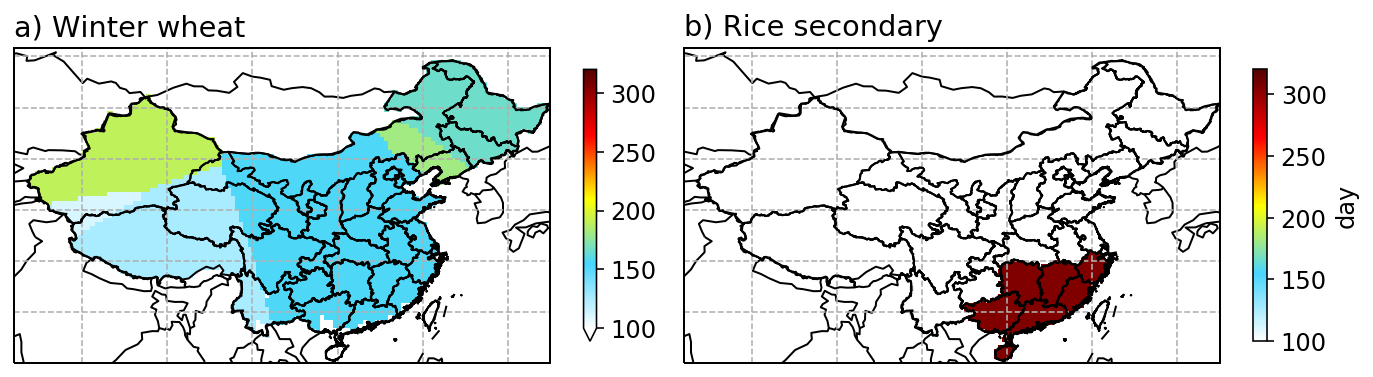

In [18]:

order_crops = ['a) Winter wheat', 'b) Rice secondary']

lim_max = 320
lim_min = 100

shrink = 0.5

# figure 1, distribution
fig, axes = plt.subplots(1, 2, 
                             figsize=[12, 5], 
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             gridspec_kw={'hspace': 0.2, 'wspace': 0})
# before
wheat2_harvest.plot(ax=axes[0],
                  cmap=WhGrYlRd,
                  vmin = lim_min,
                  vmax = lim_max, 
                  add_labels = False,
                  cbar_kwargs={'shrink': shrink})
axes[0].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[0].set_title(order_crops[0], loc='left')
axes[0].coastlines()
axes[0].gridlines(linestyle = '--')
axes[0].add_feature(cfeature.BORDERS)

# China borders
for line in borders:
    axes[0].plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

# after
rice2_harvest.plot(ax=axes[1], 
                cmap=WhGrYlRd, 
                vmin = lim_min,
                vmax = lim_max, 
                cbar_kwargs={'shrink': shrink, 'label': 'day'})
axes[1].set_extent((lon1, lon2, lat1, lat2), ccrs.PlateCarree())
axes[1].set_title(' ')
axes[1].set_title(order_crops[1], loc='left')
#axes[1].set_title('mean: ' + str(model_mean), loc = 'right')
axes[1].coastlines()
axes[1].gridlines(linestyle = '--')
axes[1].add_feature(cfeature.BORDERS)
# China borders
for line in borders:
    axes[1].plot(line[0::2], line[1::2], '-', lw=1, color='k',transform=ccrs.Geodetic())

# save figure
out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop/outputs/figures/china/'
fig.savefig(out_dir + 'harvest_date_2crops.png', dpi = 300, bbox_inches = "tight")


In [ ]:
# save as a NC file
ds_out = rice2_harvest.to_dataset(name ='rice2')
ds_out['rice'] = rice_harvest
ds_out['maize'] = maize_harvest
ds_out['soybean'] = soybean_harvest
ds_out_slice = ds_out.sel(lat = slice(lat2, lat1), lon = slice(lon1, lon2))

out_dir = '/Users/mehliyarsadiq/Desktop/ozone_crop_China/data/processed/'
ds_out_slice.to_netcdf(out_dir + 'harvest_dates.nc')